In [42]:
# Data Loading

from SPARQLWrapper import SPARQLWrapper, JSON
import utils

# TODO: caching
sparql = SPARQLWrapper("https://innovonto-core.imp.fu-berlin.de/management/core/query")
sparql.setQuery("""
    PREFIX gi2mo: <http://purl.org/gi2mo/ns#>  
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX inov:<http://purl.org/innovonto/types/#>

    SELECT ?idea ?content WHERE {
      ?idea a gi2mo:Idea;
            gi2mo:content ?content;
            gi2mo:hasIdeaContest <https://innovonto-core.imp.fu-berlin.de/entities/ideaContests/i2m-bionic-radar>.
            
    }
    ORDER BY ASC(?idea)
""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

labels = list(map(lambda binding: toLocalId(binding["idea"]["value"]),results["results"]["bindings"]))
#labels = list(map(lambda binding: truncate(binding["content"]["value"],30),results["results"]["bindings"]))

#labels = [(str(i) + " : " + str(truncate(binding["content"]["value"],60))) for i,binding in enumerate(results["results"]["bindings"])]
contents = list(map(lambda binding: binding["content"]["value"],results["results"]["bindings"]))

print(labels)

['001bba5e-645b-463a-978b-13c0b430970a', '00666826-325d-4522-8842-953fbe3365c6', '00b4f017-d00c-4057-9404-7ea10569bf0f', '01487af4-3ed1-4746-a162-2379a8e1a63a', '018cad5b-70ea-4f4e-b2a4-590eaa8138e3', '019cb2eb-d6ee-4fba-abfc-181ce89fa213', '02a5c41b-653b-4420-a3ea-a760011dbec0', '033ae853-c609-4594-a4b1-699ce2d4b248', '03506be3-5366-4900-a994-431b14b0a3a2', '04349e16-b880-41fb-86a4-0e522273c0bf', '04f538e6-e528-40e2-be7a-593d4ec870e1', '05b79c6b-4012-464c-8761-b309df6f3eca', '067b793b-e2d1-4960-9f77-ac295beb953f', '06cf6cdd-bc03-426a-a9d7-fd8a61f25232', '071578e0-1e3d-4f67-b6b5-ebfe55aa107a', '072e39a0-df2a-4cb2-8d39-b5c8024fa881', '07eb82d6-41bc-4523-b666-53f7bd8d41a7', '099ac3ee-d2ba-4f7f-a81f-ffe97a1190fb', '0a31f7b4-c1ba-4847-af90-3910b18c3e95', '0a9aafd0-079a-4ef8-b485-e25bc10c1701', '0ac26d34-11f3-4612-a30f-f73c7d2c81be', '0b155e04-b08e-4e43-bf6f-473f052abefb', '0b959bb4-5178-4dc9-990f-5ed0781c5908', '0be1e387-07fd-455d-9c96-2d1701379c92', '0bf39724-2545-4449-a2fc-74205df32e5a',

In [54]:
import pandas as pd

# Sentence Splitting
# - nltk: sent_tokenize
# nltk.download('punkt')
# a_list = nltk.tokenize.sent_tokenize(text)
#import nltk.data
# tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
# fp = open("test.txt")
#data = fp.read()
# print '\n-----\n'.join(tokenizer.tokenize(data))

# spacy
import spacy

nlp = spacy.load('en_core_web_sm')

nlp.add_pipe(nlp.create_pipe('sentencizer'))

def number_of_sentences(doc):
    sentences = [sent.string.strip() for sent in doc.sents]
    # TODO filter empty sentences
    sentences = list(filter(None, sentences))
    return len(sentences)

def number_of_words(doc):
    token_list = []
    for token in doc:
        if token and (not token.is_punct) and (not token.is_space):
            token_list.append(token.text)
    return len(token_list)

num_sentences = []
num_words = []
stringlen = []

for i in range(0,len(contents)):
    doc = nlp(contents[i])
    num_sentences.append(number_of_sentences(doc))
    num_words.append(number_of_words(doc))
    stringlen.append(len(contents[i]))
    
idea_nlp_statistics = pd.DataFrame()
idea_nlp_statistics['id'] = labels
idea_nlp_statistics['num_sentences'] = num_sentences
idea_nlp_statistics['num_words'] = num_words
idea_nlp_statistics['stringlen'] = stringlen

print(idea_nlp_statistics.head())

                                     id  num_sentences  num_words  stringlen
0  001bba5e-645b-463a-978b-13c0b430970a              1          7         58
1  00666826-325d-4522-8842-953fbe3365c6              1         18        117
2  00b4f017-d00c-4057-9404-7ea10569bf0f              1         14         76
3  01487af4-3ed1-4746-a162-2379a8e1a63a              1          4         23
4  018cad5b-70ea-4f4e-b2a4-590eaa8138e3              1         12         89


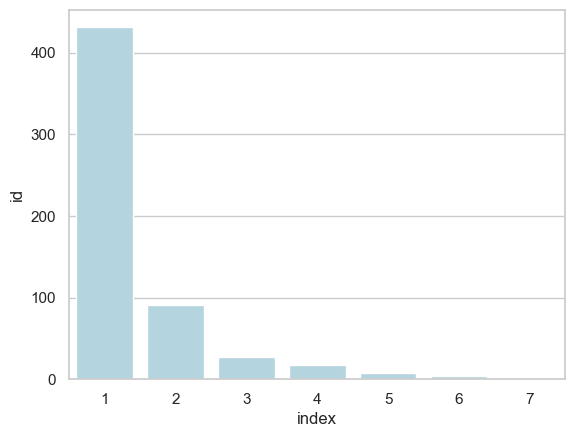

In [93]:
import seaborn as sns
sns.set(style="whitegrid")

sentence_counts = idea_nlp_statistics[['id','num_sentences']].groupby(['num_sentences']).count()
sentence_counts['index'] = sentence_counts.index

sns.barplot(x="index", y="id", data=sentence_counts, color="lightblue")

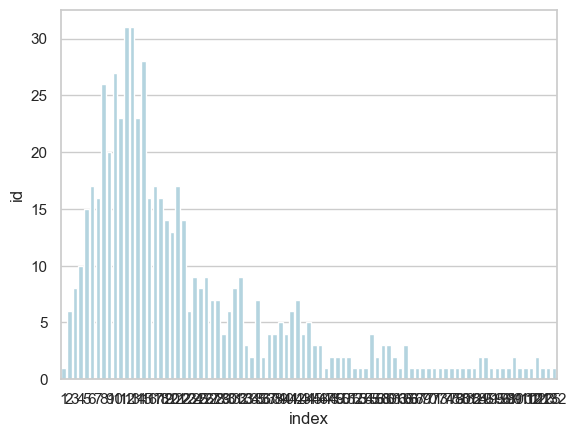

In [94]:
word_counts = idea_nlp_statistics[['id','num_words']].groupby(['num_words']).count()
word_counts['index'] = word_counts.index
sns.barplot(x="index", y="id", data=word_counts, color="lightblue")

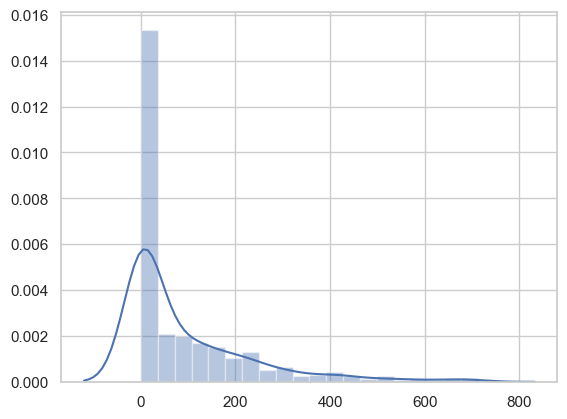

In [96]:
stringlen = idea_nlp_statistics[['id','stringlen']].groupby(['stringlen']).count()
stringlen['index'] = stringlen.index
# sns.barplot(x="index", y="id", data=stringlen, color="lightblue")
sns.distplot(stringlen)
